In [85]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from IPython.display import display, HTML

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline

df_genres = pd.read_csv('midi_dataframe_genres_flattened.csv', parse_dates=[11], index_col='file_name')

num_games = len(df_genres.groupby(['tgdb_platform', 'tgdb_gametitle']))
print('There is %d midi files, from %d games, with %d midis matched with tgdb'
      %(len(df_genres.groupby('file_name')),
        num_games,
        (df_genres.tgdb_gametitle.notnull().sum())))

df_features = pd.read_csv('features.csv').set_index('file_name')
print("There is %d midi files with computed features"%(len(df_features)))

print("After removing not valid midi files, we have %d files"%(len(df_genres.join(df_features, how='inner').groupby('file_name'))))

There is 22179 midi files, from 3243 games, with 34510 midis matched with tgdb
There is 31483 midi files with computed features
After removing not valid midi files, we have 22005 files


In [2]:
df_genres['release_year'] = pd.to_datetime(df_genres['tgdb_releasedate']).dt.year

In [27]:
df = df_genres[['brand', 'console', 'tgdb_developer', 'tgdb_publisher', 'tgdb_platform', 'release_year', 'genre']]

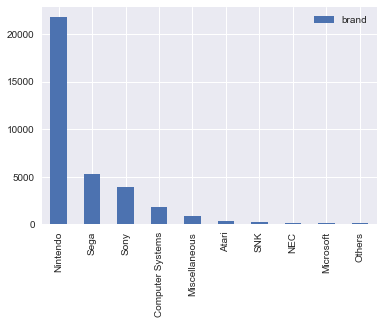

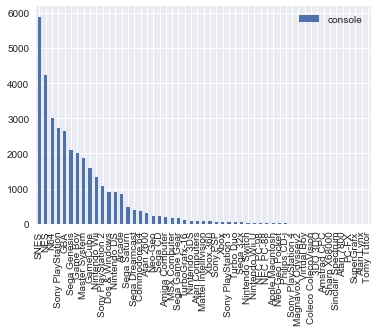

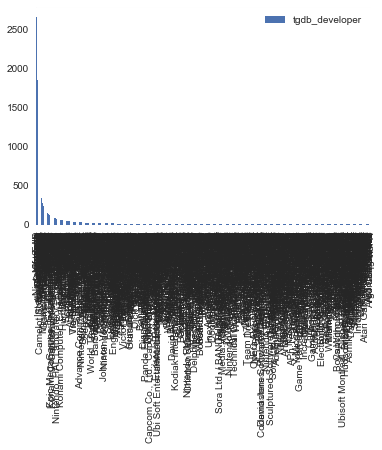

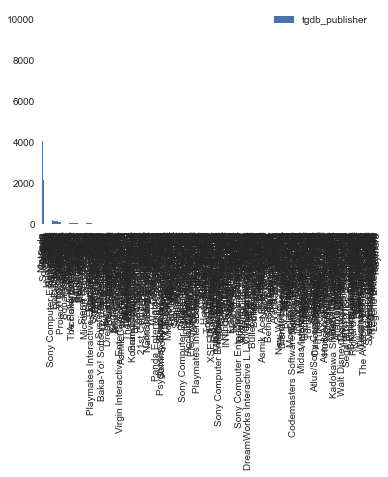

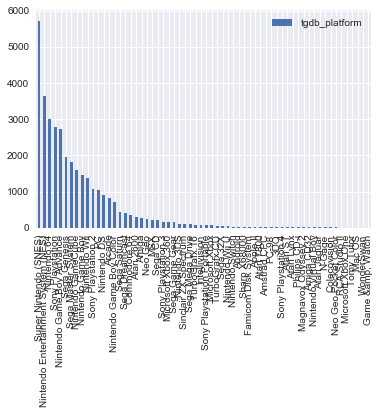

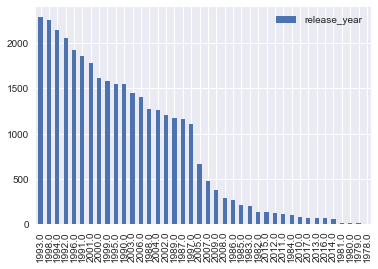

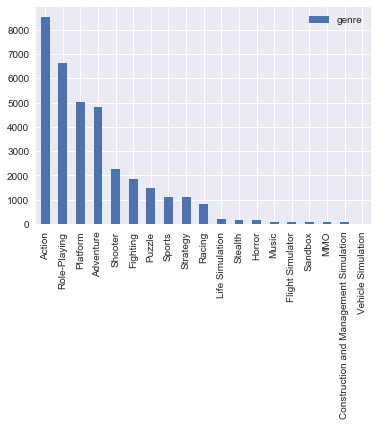

In [28]:
for column in df.columns:
    df[[column]].apply(pd.value_counts).plot.bar()

In [67]:
df_pred = df_genres[['genre']].join(df_features, how='inner').reset_index()
df_pred = df_pred.replace([np.inf, -np.inf], np.nan).dropna()
df_pred.head()

df_counts = df_pred.groupby('genre').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
df_pred_sel = df_pred[df_pred.genre.isin(df_counts[df_counts.counts > 200]['genre'])]
print("For this first analysis, %d genres entailing %d MIDIs will be considered."%(len(np.unique(df_pred_sel['genre'])), len(df_pred_sel)))
print('The genres are: %s'%", ".join(np.unique(df_pred_sel['genre'])))

print("%.3f%% of the midis are duplicates"%((len(df_pred_sel)-df_pred_sel['file_name'].nunique())/len(df_pred_sel)*100))

X = df_pred_sel.iloc[:, 2:]
y, labels = pd.factorize(df_pred_sel['genre'])

clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', multi_class="ovr", penalty="l2", C=.001))

For this first analysis, 4 genres entailing 24771 MIDIs will be considered.
The genres are: Action, Adventure, Platform, Role-Playing
32.784% of the midis are duplicates


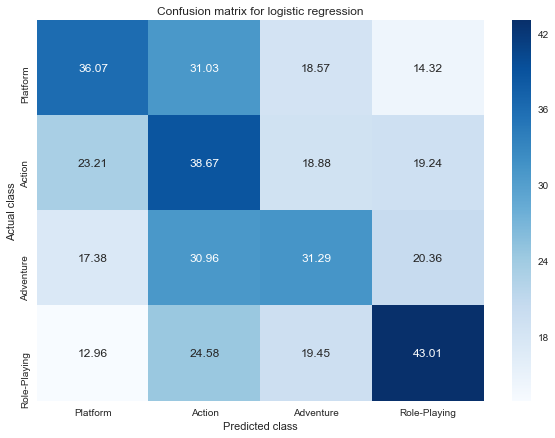

In [82]:
pred = cross_val_predict(clf, X, y, cv=5)
arr = confusion_matrix(pred, y)
arr = arr/arr.sum(axis=1).reshape(1,-1).T*100
df_cm = pd.DataFrame(arr, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))

sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion matrix for logistic regression")
plt.show();

In [52]:
selected_features = ['Duration', 'Importance_of_High_Register', 'Importance_of_Middle_Register', 'Importance_of_Bass_Register', 'Initial_Tempo', 'Metrical_Diversity']
feature_filter = (df_features['Duration'] > 5) & (df_features['Initial_Tempo'] < 400)

In [96]:
def test_with_filters(features_selection = df_features.columns, genres_filter = [True] * len(df_genres), feature_filter = [True] * len(df_features), midis_treshold=2500, repartition=False, conf_matrix=False):
    df_pred = df_genres[genres_filter][['genre']].join(df_features[features_selection][feature_filter], how='inner').reset_index()
    df_pred = df_pred.replace([np.inf, -np.inf], np.nan).dropna()
    df_pred.head()

    df_counts = df_pred.groupby('genre').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
    df_pred_sel = df_pred[df_pred.genre.isin(df_counts[df_counts.counts > midis_treshold]['genre'])]
    print("For this first analysis, %d genres entailing %d MIDIs will be considered."%(len(np.unique(df_pred_sel['genre'])), len(df_pred_sel)))
    print('The genres are: %s'%", ".join(np.unique(df_pred_sel['genre'])))

    print("%.3f%% of the midis are duplicates"%((len(df_pred_sel)-df_pred_sel['file_name'].nunique())/len(df_pred_sel)*100))

    X = df_pred_sel.iloc[:, 2:]
    y, labels = pd.factorize(df_pred_sel['genre'])

    clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', multi_class="ovr", penalty="l2", C=.001))
    scores = cross_validate(clf, X, y, cv=5, return_train_score=True)
    print("Mean train score %.3f%%, with std %.3f%%"%(scores['train_score'].mean()*100, scores['train_score'].std()*100))
    print("Mean test score %.3f%%, with std %.3f%%"%(scores['test_score'].mean()*100, scores['test_score'].std()*100))
    if repartition:
        val, counts_dataset = np.unique(y, return_counts=True)
        display(pd.DataFrame([counts_dataset/counts_dataset.sum()], columns=[labels[i] for i in val], index=['Repartition']))
    
    if conf_matrix:
        pred = cross_val_predict(clf, X, y, cv=5)
        arr = confusion_matrix(pred, y)
        arr = arr/arr.sum(axis=1).reshape(1,-1).T*100
        df_cm = pd.DataFrame(arr, index = [i for i in labels],
                  columns = [i for i in labels])
        plt.figure(figsize = (10,7))

        sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
        plt.xlabel("Predicted class")
        plt.ylabel("Actual class")
        plt.title("Confusion matrix for logistic regression")
        plt.show();
    return scores

For this first analysis, 4 genres entailing 24771 MIDIs will be considered.
The genres are: Action, Adventure, Platform, Role-Playing
32.784% of the midis are duplicates


,Platform,Action,Adventure,Role-Playing
Repartition,0.201486,0.340761,0.193492,0.264261


Mean train score 40.238%, with std 0.143%
Mean test score 39.768%, with std 0.438%


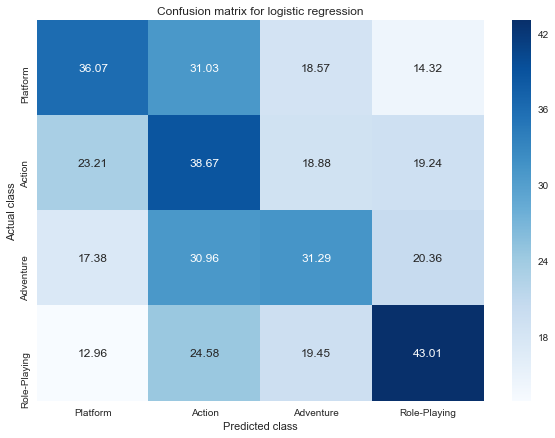

In [99]:
test_with_filters(midis_treshold=2500, repartition=True, conf_matrix=True);

In [65]:
test_with_filters(features_selection=selected_features);

For this first analysis, 4 genres entailing 24771 MIDIs will be considered.
The genres are: Action, Adventure, Platform, Role-Playing
32.784% of the midis are duplicates
Mean train score 35.228%, with std 0.184%
Mean test score 35.130%, with std 0.228%
